In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

2024-07-23 22:10:32.280065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 22:10:32.280948: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 22:10:32.284052: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 22:10:32.293262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 22:10:32.310669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
df = pd.read_csv("https://olinda.bcb.gov.br/olinda/servico/SPI/versao/v1/odata/PixLiquidadosAtual?$top=5000&$orderby=Data%20asc&$format=text/csv", decimal=',')

In [3]:
pix = df.copy()
pix.columns = ['Date', 'Quantity', 'Total', 'Mean']
pix = pix.set_index(pd.to_datetime(pix['Date'])).drop('Date', axis=1)

In [4]:
pix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1358 entries, 2020-11-03 to 2024-07-22
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Quantity  1358 non-null   int64  
 1   Total     1358 non-null   float64
 2   Mean      1358 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 42.4 KB


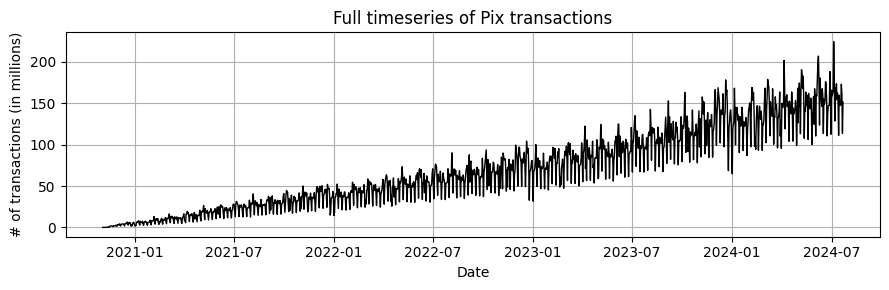

In [5]:
f, ax = plt.subplots(figsize=(9,3))
ax.plot(pix.index.values, pix['Quantity']/1e6, c='k', lw=1)

ax.set_xlabel('Date')
ax.set_ylabel('# of transactions (in millions)')
ax.set_title('Full timeseries of Pix transactions')

ax.grid(True)

plt.tight_layout()
plt.show()

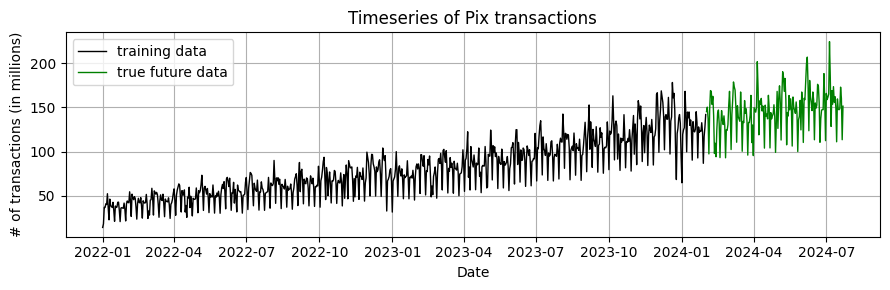

In [6]:
column = 'Quantity'

data = pix[[column]].copy()
data[column] = data[column]/1e6

data = data.resample('D').sum().ffill()

y_hist = data['2022-01-01':'2024-01-31']
y_futr = data['2024-02-01':'2024-07-27']

f, ax = plt.subplots(figsize=(9,3))

ax.plot(y_hist.index, y_hist[column], c='k', lw=1, label = 'training data')
ax.plot(y_futr.index, y_futr[column], c='g', lw=1, label = 'true future data')

ax.set_xlabel('Date')
ax.set_ylabel('# of transactions (in millions)')
ax.set_title('Timeseries of Pix transactions')

ax.grid(True)

ax.legend()

plt.tight_layout()
plt.show()

In [7]:
def create_sequences(data, seq_length, pred_length):
    Xs, ys = [], []
    for i in range(len(data) - seq_length - pred_length):
        Xs.append(data[i:(i+seq_length)])
        ys.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(Xs), np.array(ys)

In [8]:
df = pix[['Quantity']].copy()
data = df.values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [9]:
seq_length = 28
pred_length = 14

X, y = create_sequences(scaled_data, seq_length, pred_length)

split_index = int(0.7 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [10]:
model = Sequential([
    layers.Input((seq_length, 1)),
    layers.GRU(100, return_sequences=True),
    layers.LSTM(100, return_sequences=True),
    # layers.LSTM(100, return_sequences=True),
    layers.GRU(100),
    layers.Dense(pred_length, activation = 'relu'),
])
model.compile(optimizer='adam', loss='mse')

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 28, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │         1,414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,314 (677.01 KB)

 Trainable params: 173,314 (677.01 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0267 - val_loss: 0.0379
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0068 - val_loss: 0.0135
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0029 - val_loss: 0.0102
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0027 - val_loss: 0.0104
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0025 - val_loss: 0.0120
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0025 - val_loss: 0.0103
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0025 - val_loss: 0.0140
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0025 - val_loss: 0.0111
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0025 - val_loss: 0.0106
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0024 - val_loss: 0.0113
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0024 - val_loss: 0.0101
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

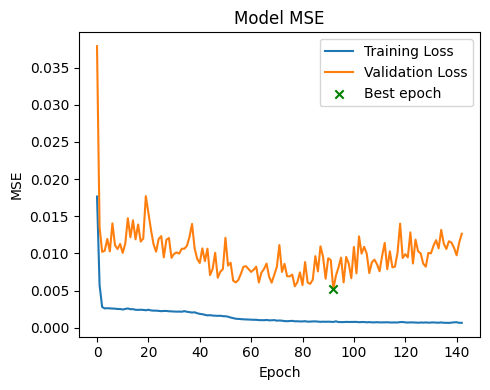

In [27]:
# 4. Plotting RMSE
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.scatter(x=92, y=history.history['val_loss'][92], zorder=10, c='g', marker='x', label = 'Best epoch')
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('23.2-mse.png')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


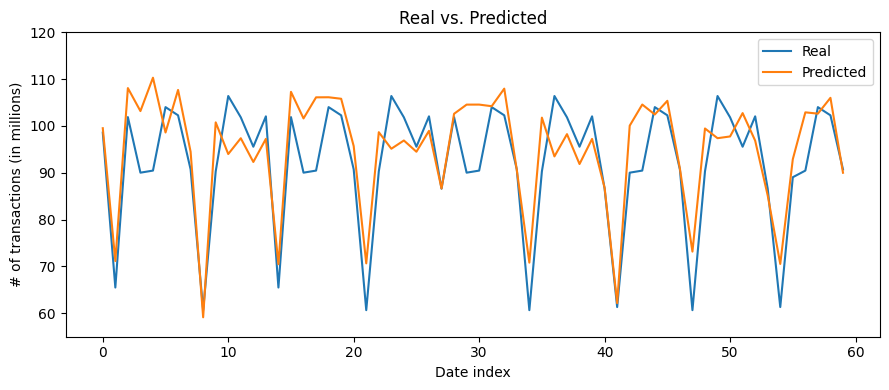

In [42]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

plot_length = 60
plt.figure(figsize=(9,4))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1))[:plot_length]/1e6, label='Real')
plt.plot(y_pred.reshape(-1, 1)[:plot_length]/1e6, label='Predicted')
plt.title('Real vs. Predicted')
plt.xlabel('Date index')
plt.ylabel('# of transactions (in millions)')
plt.ylim(55, 120)
plt.legend()
plt.tight_layout()
plt.savefig('23.2-real_v_pred.png')
plt.show()